<a href="https://colab.research.google.com/github/genaiconference/RAG_Workshop_DHS2024/blob/main/03_Basic_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic Retrieval-Augmented Generation (RAG): LangChain Implementation
**Retrieval-Augmented Generation (RAG)** is the concept to provide LLMs with additional information from an external knowledge source.

This allows them to generate more accurate and contextual answers while reducing hallucinations.

RAG is a general methodology to connect LLMs to external data, using

(1) indexing (make external data retrievable),

(2) retrieval (fetch external data that is relevant to a query that we want the LLM to reason about,

(3) generation pass this to an LLM to generate an answer.


# Introduction

Large Language Models (LLMs) are powerful tools for generating human-like text, but they have limitations.

Retrieval Augmented Generation (RAG) addresses these challenges, enhancing LLMs by integrating retrieval mechanisms. This approach ensures that the content LLMs produce is both contextually relevant and factually accurate. RAG acts as a bridge, connecting LLMs to vast knowledge sources. As AI becomes increasingly used for diverse tasks, the accuracy and relevance of the generated information are crucial.

RAG meets this demand, making AI interactions more informative and context-aware.

# Building Blocks of a RAG System

Before building out a RAG system, it's essential to familiarize yourself with the tools that make this process possible.

Each tool plays a specific role, ensuring that the RAG system operates efficiently and effectively.

**LLM**: At the heart of the system is the LLM, the core AI model responsible for generating human-like text responses.

**Document Loader**: With vast amounts of data to process, the Document Loader is essential. It imports and reads documents, preparing them for chunking and embedding.

**Document Chunker**: To make the data more manageable and efficient for retrieval, the Document Chunker breaks documents into smaller, more digestible pieces.

**Embedder**: Before storing or retrieving data, we need to convert textual information into a format the system can understand. The Embedder takes on this role, transforming text into vector representations.

**Vector Store**: This is where the magic happens. The Vector Store is a dedicated storage system that houses embeddings and their corresponding textual data, ensuring quick and efficient retrieval.

**Vector Store Retriever**: Think of this as the search engine of the system. The Vector Store Retriever fetches relevant documents by comparing vector similarities, ensuring that the most pertinent information is always at hand.

**Prompt**: Every interaction starts with a user's query or statement. The Prompt captures this initial input, setting the stage for the retrieval and generation processes.

**User Input**: Last but not least, the User Input tool captures the query or statement provided by the end-user, initiating the entire RAG process.


# The RAG System and Its Subsystems

The primary goal of RAG is to provide LLMs with contextually relevant and factually accurate information, ensuring that the generated content meets the highest standards of quality and relevance.

To achieve this, the RAG system is divided into subsystems, each playing a crucial role in the overall process. The tools integral to the RAG system are not standalone entities; they interweave to form the subsystems that drive the RAG process.

Each tool fits within one of the following subsystems:

1) Index

2) Retrieval

3) Augment

These work together as an orchestrated flow that transforms a user's query into a contextually rich and accurate response.


RAG, introduced by Meta is a powerful technique that combines **prompt engineering with context retrieval from external data sources** to improve the performance and relevance of LLMs.

By grounding the model on additional information, it allows for more accurate and context-aware responses.

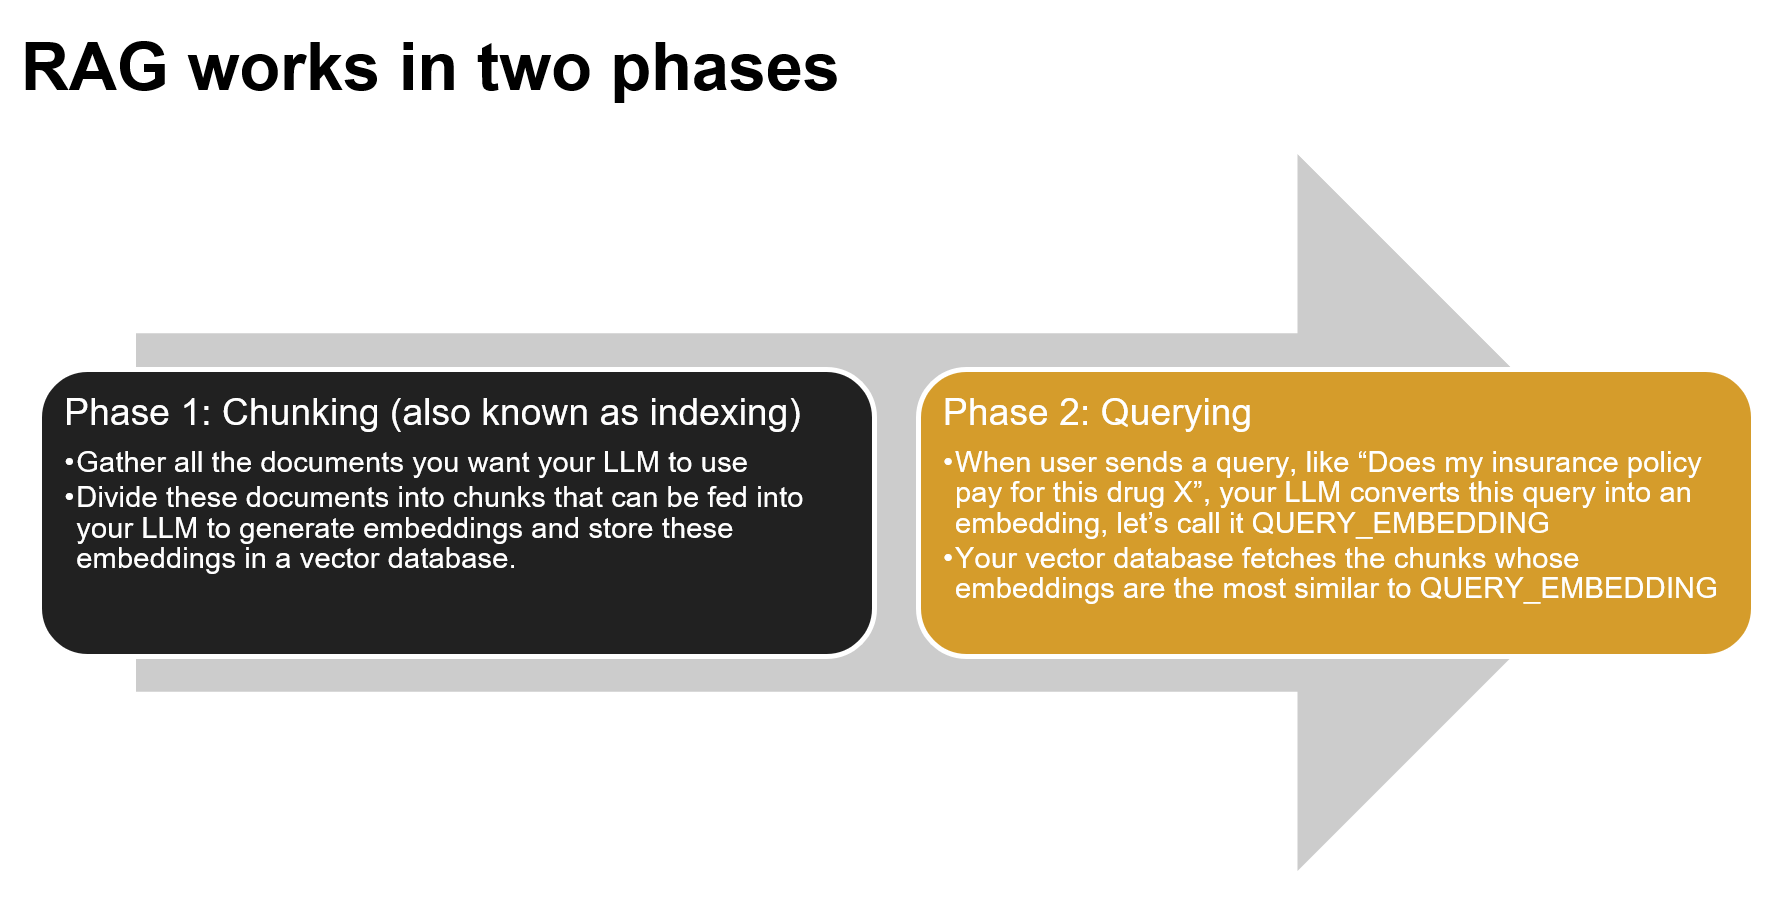

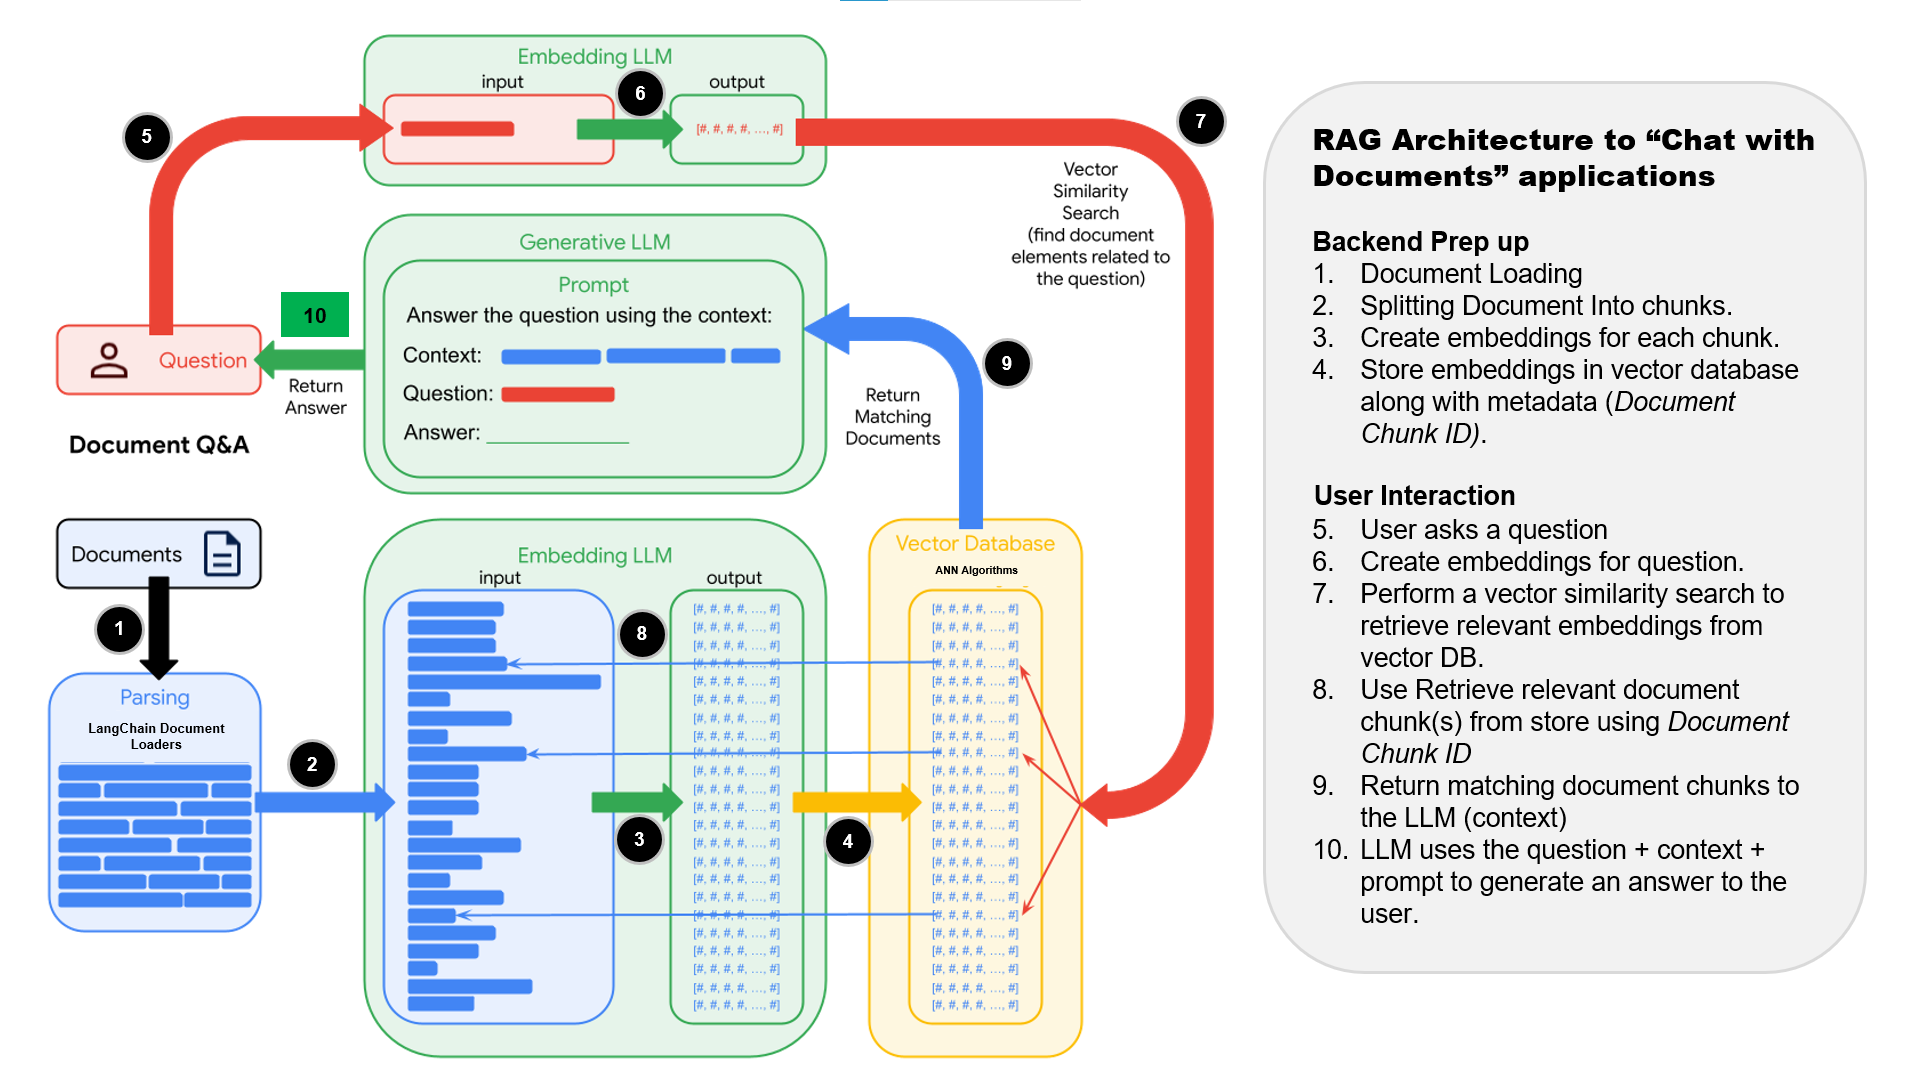

## Prerequisites
Make sure you have installed the required Python packages:

* langchain for orchestration
* openai for the embedding model and LLM
* faiss-cpu for the vectorstore

In [2]:
!git clone https://github.com/genaiconference/RAG_Workshop_DHS2024.git

Cloning into 'RAG_Workshop_DHS2024'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 57 (delta 12), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (57/57), 29.28 MiB | 8.71 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [ ]:
!pip install -r /content/RAG_Workshop_DHS2024/rag_requirements.txt

In [6]:
import os
import warnings
warnings.filterwarnings("ignore")

from dotenv import load_dotenv
load_dotenv()

True

## Azure Configuration
Define relevant environment variables in a .env file

In [7]:
import openai
# if directly using open ai api key
openai.api_key = os.getenv("OPENAI_API_KEY")
openai.api_type = "openai"

In [ ]:
# # Fetch the Azure Open AI env variables
# GPT4_DEPLOYMENT_NAME = os.getenv('GPT4_DEPLOYMENT_NAME')
# GPT4_TURBO_DEPLOYMENT_NAME = os.getenv('GPT4_TURBO_DEPLOYMENT_NAME')

# API_KEY = os.getenv('API_KEY')
# API_BASE = os.getenv('API_BASE')
# API_TYPE = os.getenv('API_TYPE')
# API_VERSION = os.getenv('API_VERSION')


# EMBEDDING_API_KEY = os.getenv('API_KEY')
# EMBEDDING_API_BASE = os.getenv('API_BASE')
# EMBEDDING_DEPLOYMENT_NAME = os.getenv('EMBEDDING_DEPLOYMENT_NAME')

## RAG Process Flow
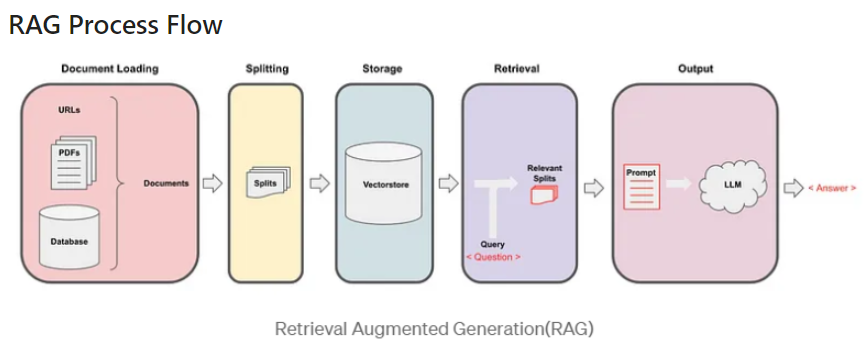

## Step1: Document Loading
We use LangChain’s document loaders for this purpose.

Document loaders deal with the specifics of accessing and converting data from a variety of different formats and sources into a standardized format.

We may have to load from structured data sources or unstructured data sources.

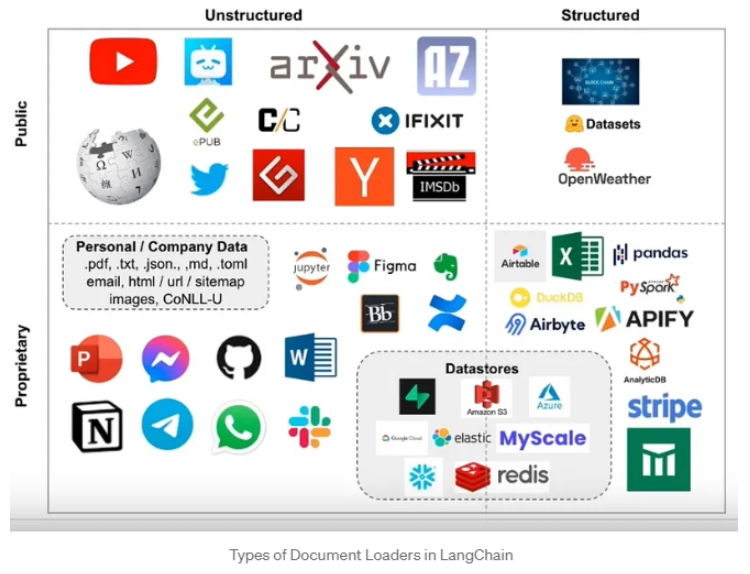

##### PyPDF DataLoader

In [8]:
from langchain.document_loaders import PyPDFLoader

loader = PyPDFLoader(file_path='/content/RAG_Workshop_DHS2024/data/Microsoft_2023.pdf')
documents = loader.load()
len(documents)

116

## Step2: Document Splitting

Often times your document is too long (like a book) for your LLM. You need to split it up into chunks. Text splitters help with this.


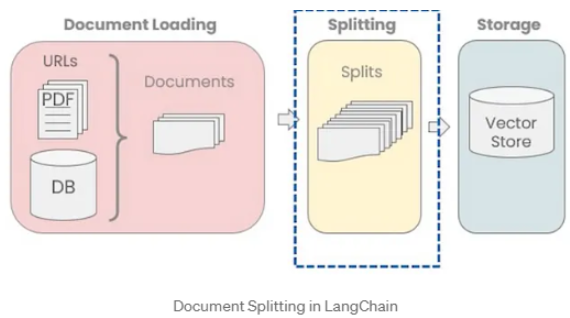

**Can we use the whole book as is on ChatGPT?**
* When working with a whole book, copying and pasting it into chatGPT won't work due to the limitations of LLMs in processing large amounts of text at once.

**What is a context window?**
* LLMs have a context window, which is the span of text or tokens the model uses to generate or understand specific words or sequences within a sentence or text.
* The context window determines how much surrounding text the model considers for predictions or language processing.
* Due to the limitations of the context window, it is necessary to split the loaded PDF file into smaller sections referred to as "chunks" that can fit within the context window.

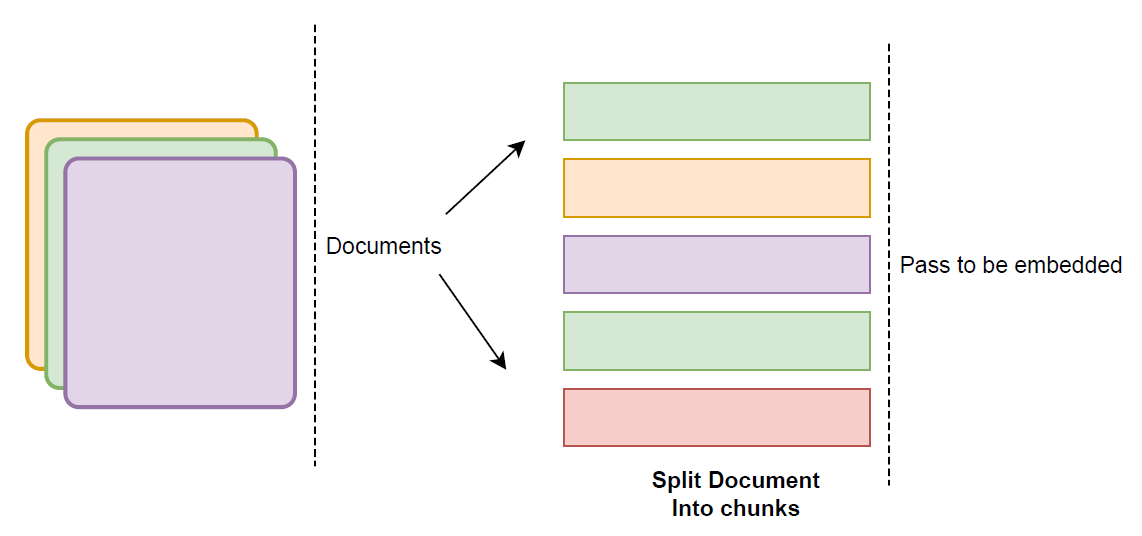

The input text is split based on a defined chunk size with some defined chunk overlap.

**Chunk Size** is a length function to measure the size of the chunk. This is often characters or tokens.

**Chunk Overlap** is used to have little overlap between two chunks and this allows for to have some notion of consistency between 2 chunks

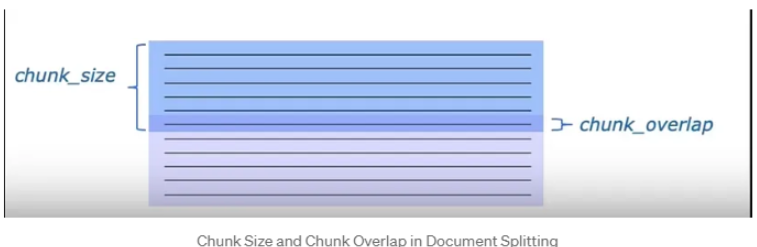

#### Example

In [9]:
from langchain.text_splitter import RecursiveCharacterTextSplitter, CharacterTextSplitter
from IPython.display import Markdown

some_text = """When writing documents, writers will use document structure to group content. \
This can convey to the reader, which idea's are related. For example, closely related ideas \
are in sentances. Similar ideas are in paragraphs. Paragraphs form a document. \n\n  \
Paragraphs are often delimited with a carriage return or two carriage returns. \
Carriage returns are the "backslash n" you see embedded in this string. \
Sentences have a period at the end, but also, have a space.\
and words are separated by space."""


In [10]:
# let's check the len of the text
len(some_text)

496

In [11]:
Markdown(some_text)

When writing documents, writers will use document structure to group content. This can convey to the reader, which idea's are related. For example, closely related ideas are in sentances. Similar ideas are in paragraphs. Paragraphs form a document. 

  Paragraphs are often delimited with a carriage return or two carriage returns. Carriage returns are the "backslash n" you see embedded in this string. Sentences have a period at the end, but also, have a space.and words are separated by space.

Playground  : https://langchain-text-splitter.streamlit.app/

#### Type1 - Character Text Splitter
Implementation of splitting text that looks at characters.

In [12]:
c_splitter = CharacterTextSplitter(
    chunk_size=450,
    chunk_overlap=0,
    separator = ' '  # CharacterTextSplitter uses space as a separator
)

c_splitter.split_text(some_text)

['When writing documents, writers will use document structure to group content. This can convey to the reader, which idea\'s are related. For example, closely related ideas are in sentances. Similar ideas are in paragraphs. Paragraphs form a document. \n\n Paragraphs are often delimited with a carriage return or two carriage returns. Carriage returns are the "backslash n" you see embedded in this string. Sentences have a period at the end, but also,',
 'have a space.and words are separated by space.']

In [13]:
len(c_splitter.split_text(some_text))

2

chunk size is 450 hence it has made 2 chunks

#### Type2 - RecursiveCharacter Text Splitter
Implementation of splitting text that looks at characters. Recursively tries to split by different characters to find one that works.

In [14]:
r_splitter = RecursiveCharacterTextSplitter(
    chunk_size=450,
    chunk_overlap=0,
    separators=["\n\n", "\n", " ", ""]   # We pass a list of separators to RecursiveCharacterText Splitter
)
r_splitter.split_text(some_text)

["When writing documents, writers will use document structure to group content. This can convey to the reader, which idea's are related. For example, closely related ideas are in sentances. Similar ideas are in paragraphs. Paragraphs form a document.",
 'Paragraphs are often delimited with a carriage return or two carriage returns. Carriage returns are the "backslash n" you see embedded in this string. Sentences have a period at the end, but also, have a space.and words are separated by space.']

#### Type3 -  Token Text Splitter
Split based on token count

In [15]:
from langchain.text_splitter import TokenTextSplitter

text_splitter = TokenTextSplitter(chunk_size=1, chunk_overlap=0)

# text1 = "foo bar bazzy foo industrialization"
text_splitter.split_text(some_text)

['When',
 ' writing',
 ' documents',
 ',',
 ' writers',
 ' will',
 ' use',
 ' document',
 ' structure',
 ' to',
 ' group',
 ' content',
 '.',
 ' This',
 ' can',
 ' convey',
 ' to',
 ' the',
 ' reader',
 ',',
 ' which',
 ' idea',
 "'s",
 ' are',
 ' related',
 '.',
 ' For',
 ' example',
 ',',
 ' closely',
 ' related',
 ' ideas',
 ' are',
 ' in',
 ' sent',
 'ances',
 '.',
 ' Similar',
 ' ideas',
 ' are',
 ' in',
 ' paragraphs',
 '.',
 ' Par',
 'agraph',
 's',
 ' form',
 ' a',
 ' document',
 '.',
 ' ',
 '\n\n',
 ' ',
 ' Par',
 'agraph',
 's',
 ' are',
 ' often',
 ' delim',
 'ited',
 ' with',
 ' a',
 ' carriage',
 ' return',
 ' or',
 ' two',
 ' carriage',
 ' returns',
 '.',
 ' Car',
 'riage',
 ' returns',
 ' are',
 ' the',
 ' "',
 'back',
 'sl',
 'ash',
 ' n',
 '"',
 ' you',
 ' see',
 ' embedded',
 ' in',
 ' this',
 ' string',
 '.',
 ' Sent',
 'ences',
 ' have',
 ' a',
 ' period',
 ' at',
 ' the',
 ' end',
 ',',
 ' but',
 ' also',
 ',',
 ' have',
 ' a',
 ' space',
 '.',
 'and',
 ' words',
 

In [16]:
from langchain.text_splitter import TokenTextSplitter

text_splitter = TokenTextSplitter(chunk_size=3, chunk_overlap=1)

# text1 = "foo bar bazzyfoo industrialization"
text_splitter.split_text(some_text)

['When writing documents',
 ' documents, writers',
 ' writers will use',
 ' use document structure',
 ' structure to group',
 ' group content.',
 '. This can',
 ' can convey to',
 ' to the reader',
 ' reader, which',
 " which idea's",
 "'s are related",
 ' related. For',
 ' For example,',
 ', closely related',
 ' related ideas are',
 ' are in sent',
 ' sentances.',
 '. Similar ideas',
 ' ideas are in',
 ' in paragraphs.',
 '. Paragraph',
 'agraphs form',
 ' form a document',
 ' document. ',
 ' \n\n ',
 '  Paragraph',
 'agraphs are',
 ' are often delim',
 ' delimited with',
 ' with a carriage',
 ' carriage return or',
 ' or two carriage',
 ' carriage returns.',
 '. Carriage',
 'riage returns are',
 ' are the "',
 ' "backsl',
 'slash n',
 ' n" you',
 ' you see embedded',
 ' embedded in this',
 ' this string.',
 '. Sentences',
 'ences have a',
 ' a period at',
 ' at the end',
 ' end, but',
 ' but also,',
 ', have a',
 ' a space.',
 '.and words',
 ' words are separated',
 ' separated by sp

#### Type4 -  Context-aware splitting
Preserves header metadata in our chunks. It splits a markdown file based on the header or any subheaders and then it adds those headers as content to the metadata fields

In [17]:
from langchain.text_splitter import MarkdownHeaderTextSplitter

markdown_document = """# Title (H1)\n\n \
This is part of Title (H1)
## Chapter 1 (H2)\n\n \
I'm part of Chapter 1(H2) under Title (H1)\n\n \
### Section (H3) \n\n \
I'm part of  Section (H3) and I belong to  Chapter 1 (H2) of Title(H1) \n\n
## Chapter 2(H2)\n\n \
I'm part of Chapter 2(H2) under Title (H1)"""

Let's see how the markdown doc looks like

In [18]:
Markdown(markdown_document)

# Title (H1)

 This is part of Title (H1)
## Chapter 1 (H2)

 I'm part of Chapter 1(H2) under Title (H1)

 ### Section (H3) 

 I'm part of  Section (H3) and I belong to  Chapter 1 (H2) of Title(H1) 


## Chapter 2(H2)

 I'm part of Chapter 2(H2) under Title (H1)

In [19]:
# We define the hierarchy of headers to split on. First H1, then H2 followed by H3
headers_to_split_on = [
    ("#", "Header 1"),
    ("##", "Header 2"),
    ("###", "Header 3"),
]

markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on) # define MarkdownHeaderTextSplitter
md_header_splits = markdown_splitter.split_text(markdown_document)

In [20]:
# let's checkk the total number of splits
len(md_header_splits)

4

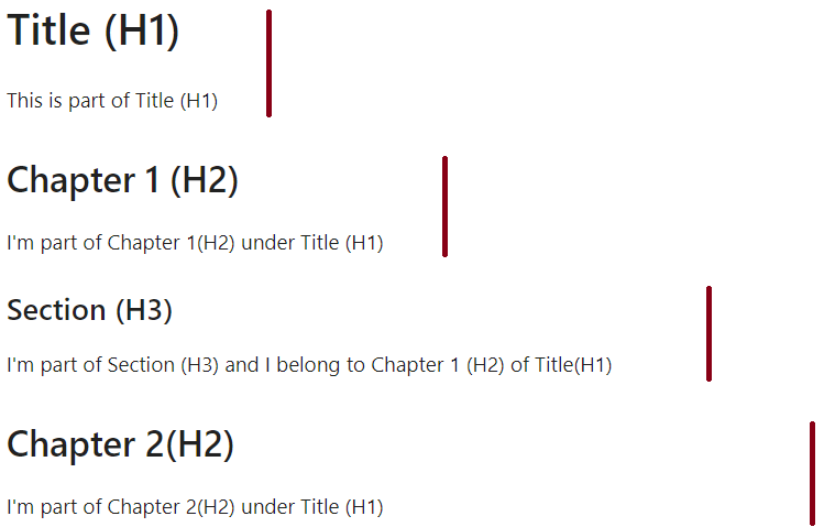

In [21]:
md_header_splits[0]

Document(page_content='This is part of Title (H1)', metadata={'Header 1': 'Title (H1)'})

In [22]:
md_header_splits[1]

Document(page_content="I'm part of Chapter 1(H2) under Title (H1)", metadata={'Header 1': 'Title (H1)', 'Header 2': 'Chapter 1 (H2)'})

In [23]:
md_header_splits[2]

Document(page_content="I'm part of  Section (H3) and I belong to  Chapter 1 (H2) of Title(H1)", metadata={'Header 1': 'Title (H1)', 'Header 2': 'Chapter 1 (H2)', 'Header 3': 'Section (H3)'})

In [24]:
md_header_splits[3]

Document(page_content="I'm part of Chapter 2(H2) under Title (H1)", metadata={'Header 1': 'Title (H1)', 'Header 2': 'Chapter 2(H2)'})

Now let's ignore the split at H2

In [25]:
# We define the hierarchy of headers to split on. First H1, then H2 followed by H3
headers_to_split_on = [
    ("#", "Header 1"),
    ("##", "Header 2"),
]

markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on) # define MarkdownHeaderTextSplitter
md_header_splits = markdown_splitter.split_text(markdown_document)

In [26]:
len(md_header_splits)

3

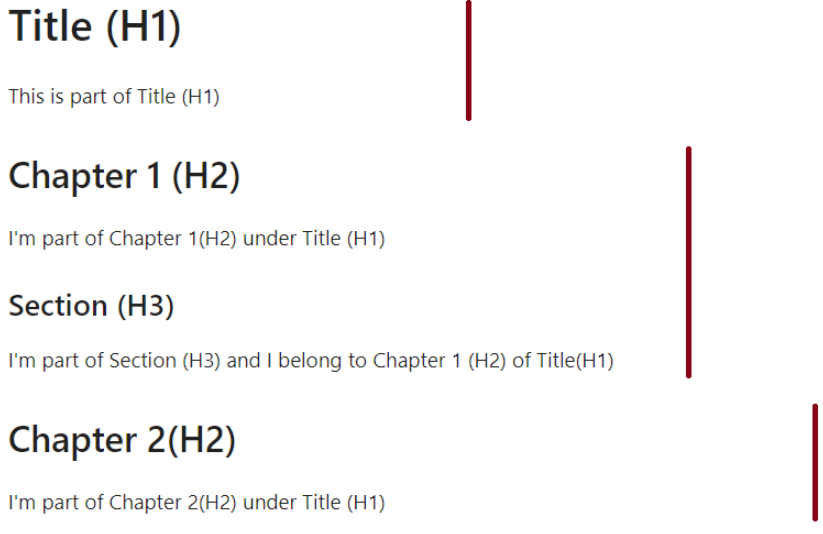

In [27]:
md_header_splits

[Document(page_content='This is part of Title (H1)', metadata={'Header 1': 'Title (H1)'}),
 Document(page_content="I'm part of Chapter 1(H2) under Title (H1)  \n### Section (H3)  \nI'm part of  Section (H3) and I belong to  Chapter 1 (H2) of Title(H1)", metadata={'Header 1': 'Title (H1)', 'Header 2': 'Chapter 1 (H2)'}),
 Document(page_content="I'm part of Chapter 2(H2) under Title (H1)", metadata={'Header 1': 'Title (H1)', 'Header 2': 'Chapter 2(H2)'})]

#### TextSplitter for our PDF

In [28]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

def chunkByWord(text):
    return len(text.split(" "))

text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, length_function = chunkByWord, chunk_overlap=50, add_start_index = False)
splits = text_splitter.split_documents(documents)
len(splits)

239

## Step3: Vector Stores & Embeddings

An embedding is a numerical representation of a piece of information - text, documents, images, audio, etc.

Now, let’s ingest documents into Faiss so we can efficiently query our embeddings

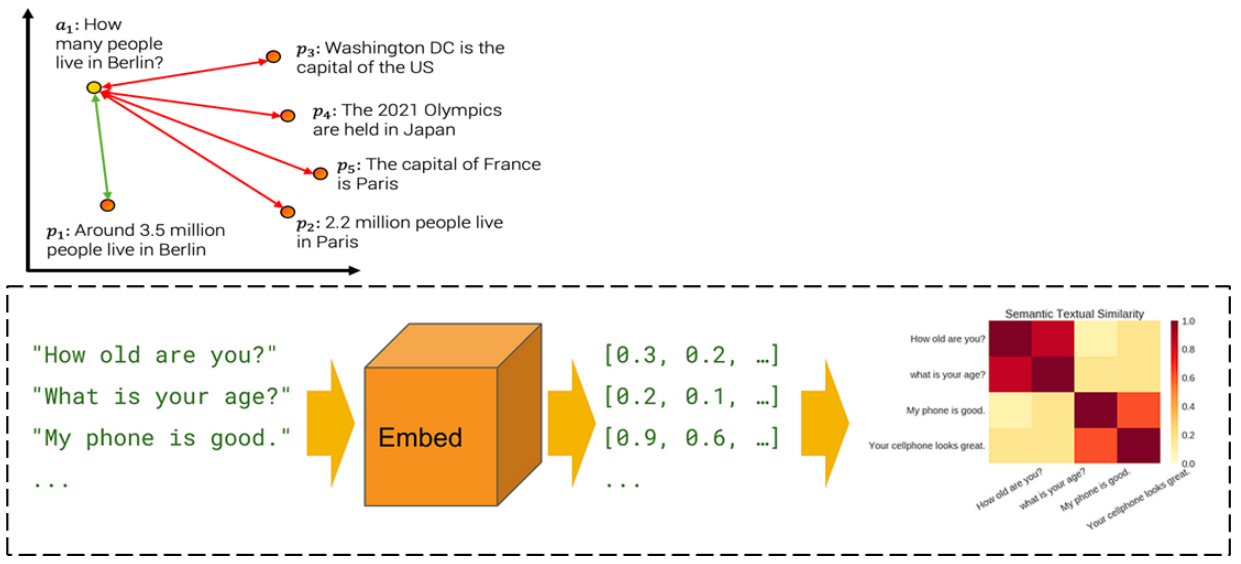


Vector databases are a new database category that stores vectors or embeddings. They also help in similarity searches.
Most popular ones are Pinecone & Weaviate. Chroma & FAISS are easy to work with locally.

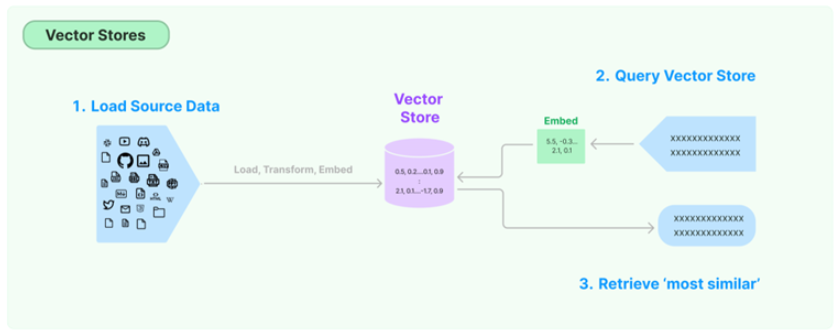

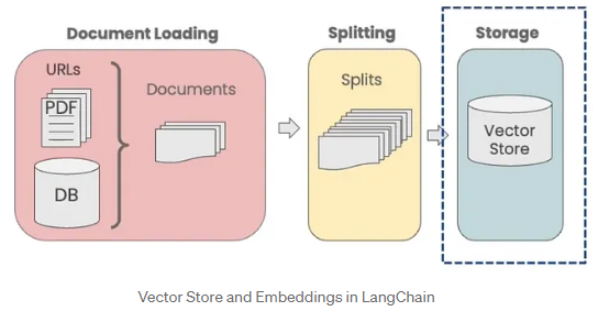

Now, we will create embeddings for all the chunks of the PDFs and then store them in a vector store. We use OpenAI to create these embeddings.

We will use Chroma as the vector store in our case. Chroma is lightweight and in memory making it easy to start with.

In [29]:
from langchain.embeddings.openai import OpenAIEmbeddings

# Open AI way
embeddings = OpenAIEmbeddings()

# Azure Open AI way
# embeddings = OpenAIEmbeddings(deployment=EMBEDDING_DEPLOYMENT_NAME,
#                               openai_api_key=EMBEDDING_API_KEY,
#                               openai_api_base=EMBEDDING_API_BASE,
#                               openai_api_version=API_VERSION,
#                               openai_api_type=API_TYPE,
#                               chunk_size=1)

We save this vector store in a persistent directory so that we can use it in future.

In [30]:
from langchain.vectorstores import Chroma

persist_directory = os.getcwd() +'/vectorstore/chroma/'

# Create the vector store
vectordb = Chroma.from_documents(
    documents=splits,
    embedding=embeddings,
    persist_directory=persist_directory
)

print(vectordb._collection.count())

239


### Easy Understanding so far...
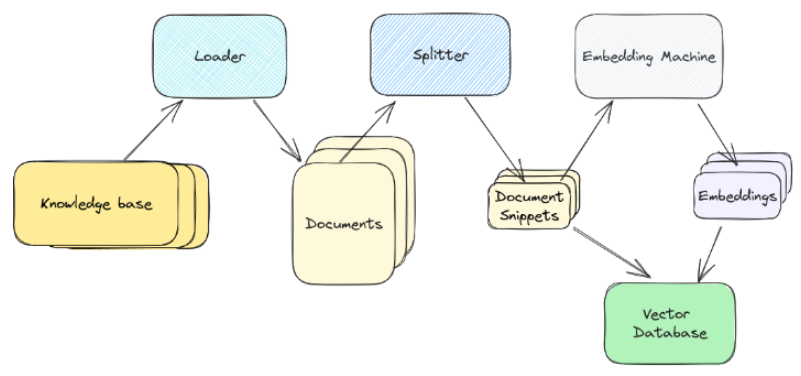

## Step4: Retrieval

Retrieval is the centrepiece of our retrieval augmented generation (RAG) flow. Retrieval is important at query time when a query comes in and we want to retrieve the most relevant splits.

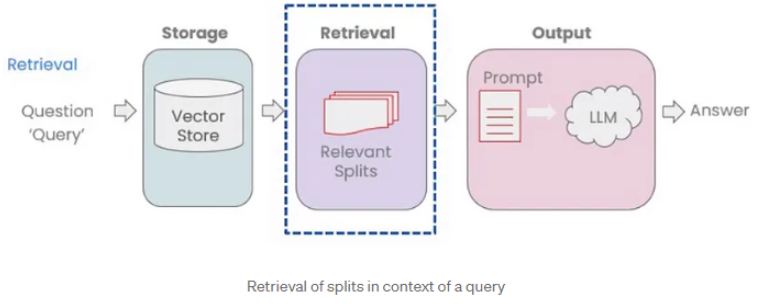

### Retrieve
Once the vector database is populated, you can define it as the retriever component, which fetches the additional context based on the semantic similarity between the user query and the embedded chunks.

In [31]:
retriever = vectordb.as_retriever(search_type="similarity",
                                     search_kwargs={"k": 3, "include_metadata": True})

### Augment
Next, to augment the prompt with the additional context, you need to prepare a prompt template. The prompt can be easily customized from a prompt template, as shown below.

In [32]:
from langchain.prompts import ChatPromptTemplate

template = """You are an assistant for question-answering tasks.
Use the following pieces of retrieved context to answer the question.
If you don't know the answer, just say that you don't know.
Use three sentences maximum and keep the answer concise.
Avoid using generic phrases like "Provide context" or "as per context.

Question: {question}

Context: {context}

Answer:
"""
prompt = ChatPromptTemplate.from_template(template)

### Generate
Finally, you can build a chain for the RAG pipeline, chaining together the retriever, the prompt template and the LLM. Once the RAG chain is defined, you can invoke it.

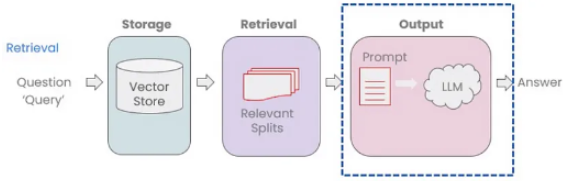

#### Memory Module

We can now create a memory object, which is necessary to track the inputs/outputs and hold a conversation.

In [33]:
from langchain.memory import ConversationBufferMemory
from typing import Dict, Any

class CustomConversationBufferMemory(ConversationBufferMemory):
    def save_context(self, inputs: Dict[str, Any], outputs: Dict[str, str]) -> None:
        return super(CustomConversationBufferMemory, self).save_context(inputs,{'response': outputs['answer']})

# define memory object
memory = CustomConversationBufferMemory(memory_key="chat_history", return_messages=True)

#### LLM

We can now create a LLM object, which is necessary to answer questions using the context provided

In [39]:
from langchain.chat_models import AzureChatOpenAI, ChatOpenAI

# Open AI way
llm = ChatOpenAI(model="gpt-4o-mini",temperature=0)

# Azure Open AI way
# llm = AzureChatOpenAI(
#         openai_api_base=API_BASE,
#         openai_api_version=API_VERSION,
#         deployment_name=GPT4_TURBO_DEPLOYMENT_NAME,
#         openai_api_key=API_KEY,
#         openai_api_type=API_TYPE,
#         temperature=0
#     )

#### Chains

Lets define a chain as our last step which allow us to combine multiple components (all above defined) together to create a single, coherent application.

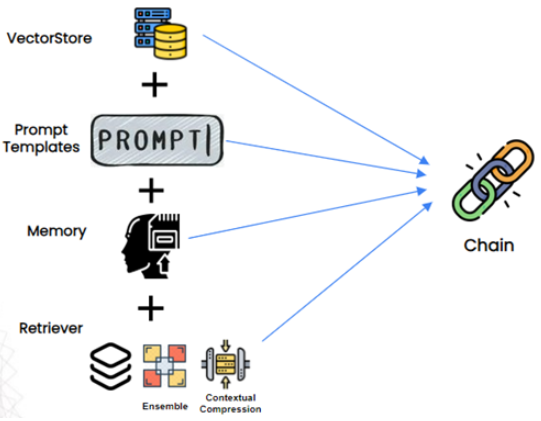

In [40]:
from langchain.chains import ConversationalRetrievalChain
from IPython.display import Markdown

In [41]:
chain = ConversationalRetrievalChain.from_llm(llm=llm,
                                           combine_docs_chain_kwargs={"prompt": prompt},
                                          retriever=retriever,
                                           memory=memory,
                                           return_source_documents=True)

In [42]:
def pretty_print_result(result):
    """
    Custom function to print clean output
    """
    display(Markdown("Answer: " + result["answer"]))
    print("=============================================================================================================")
    display(Markdown(f"\n{'-.' * 100}\n\n".join([f"Document {i+1}:\n\n" + d.page_content +"\n\n" + str(d.metadata) for i, d in enumerate(result['source_documents'])])))
    return

In [43]:
query = "Describe about Microsoft's Intelligent cloud"
result = chain({"question": query})
pretty_print_result(result)

Answer: Microsoft's Intelligent Cloud segment includes public, private, and hybrid server products and cloud services, primarily centered around Azure, SQL Server, and GitHub. Azure provides a comprehensive set of cloud services for building, deploying, and managing applications, leveraging AI and machine learning capabilities. The segment also encompasses enterprise services and aims to optimize business processes through advanced technology and infrastructure.

Document 1:

Our Intelligent Cloud segment consists of our public, private, and hybrid server products and cloud services that can 
power modern business and developers. This segment primarily comprises:  
• Server products and cloud services, including Azure and other cloud services; SQL Server, Windows 
Server, Visual Studio, System Center, and related Client Access Licenses (“CALs”); and Nuance and 
GitHub.  
• Enterprise Services, including Enterprise Support Services, Industry Solutions (formerly Microsoft 
Consulting Services ), and Nuance professional services.  
Server Products and Cloud Services  
Azure is a comprehensive set of cloud services that offer developers, IT professionals, and enterprises freedom to 
build, deploy, and manage applications on any platform or device. Customers can use Azure through our global network 
of datacenters for compu ting, networking, storage, mobile and web application services, AI, IoT, cognitive services, 
and machine learning. Azure enables customers to devote more resources to development and use of applications 
that benefit their organizations, rather than managin g on-premises hardware and software. Azure revenue is mainly 
affected by infrastructure -as-a-service and platform -as-a-service consumption -based services, and per user -based 
services such as Enterprise Mobility + Security.  
Azure AI offerings provide a competitive advantage as companies seek ways to optimize and scale their business with 
machine learning. Azure’s purpose -built, AI -optimized infrastructure allows advanced models, including GPT -4 
services designed for developer s and data scientists, to do more with less. Customers can integrate large language 
models and develop the next generation of AI apps and services.

{'page': 11, 'source': '/content/RAG_Workshop_DHS2024/data/Microsoft_2023.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 2:

PART I  
Item 1 
 
4 The Ambitions That Drive Us  
To achieve our vision, our research and development efforts focus on three interconnected ambitions:  
• Reinvent productivity and business processes.  
• Build the intelligent cloud and intelligent edge platform.  
• Create more personal computing.  
Reinvent Productivity and Business Processes  
At Microsoft, we provide technology and resources to help our customers create a secure , productive  work 
environment. Our family of products plays a key role in the ways the world works, learns, and connects.  
Our growth depends on securely delivering continuous innovation and advancing our leading productivity and 
collaboration tools and services, including Office 365, Dynamics 365, and LinkedIn. Microsoft 365 brings together 
Office 365, Windows, and Enterprise  Mobility + Security to help organizations empower their employees with AI -backed 
tools that unlock creativity, increase collaboration, and fuel innovation, all the while enabling compliance coverage and 
data protection. Microsoft Teams is a comprehensive platform for work, with meetings, calls, chat, collaboration, and 
business process automation. Microsoft Viva is an employee experience platform that brings together communications, 
knowledge, learning, resources, and insights. Microsoft 365 Copilot combines next -generation AI with business data 
in the Microsoft Graph and Microsoft 365 applications.  
Together with the Microsoft Cloud, Dynamics 365, Microsoft Teams, and our AI offerings  bring a new era of 
collaborative applications that optimize  business function s, process es, and applications to better serve customers and 
employees while creating more business value . Microsoft Power Platform is helping domain experts drive productivity 
gains with low -code/no -code tools, robotic process automation, virtual agents, and business intelligence. In a dynamic 
labor market, LinkedIn is helping professionals use the platform to connect, learn, grow, and get hired.  
Build the Intelligent Cloud and Intelligent Edge Platform  
As digital transformation and adoption of AI accelerates  and revolutionizes more business workstreams , organizations 
in every sector across the globe can address challenges that will have a fundamental impact on their success. For 
enterprises, digital technology empowers employees, optimizes operations, engages customers, and in some cases, 
changes the ve ry core of products and services. We continue to invest in high performance and sustainable computing 
to meet the growing demand for fast access to Microso ft services provided by our network of cloud computing 
infrastructure and datacenters.  
Our cloud business benefits from three economies of scale: datacenters that deploy computational resources at 
significantly lower cost per unit than smaller ones; datacenters that coordinate and aggregate diverse customer,

{'page': 4, 'source': '/content/RAG_Workshop_DHS2024/data/Microsoft_2023.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 3:

PART I  
Item 1 
 
5 industry clouds bring together capabilities across the entire Microsoft Cloud, along with industry -specific 
customizations. Azure Arc simplifies governance and management by delivering a consistent multi -cloud and on -
premises management platform.  
Nuance, a leader in conversational AI and ambient intelligence across industries including healthcare, financial 
services, retail, and telecommunications, joined Microsoft in 2022. Microsoft and Nuance enable organizations to 
accelerate their business goal s with security -focused, cloud -based solutions infused with AI.  
We are accelerating our development of mixed reality solutions with new Azure services and devices. Microsoft Mesh 
enables organizations to create custom, immersive experiences for the workplace to help bring remote and hybrid 
workers and teams together .  
The ability to convert data into AI drives our competitive advantage. The Microsoft Intelligent Data Platform is a leading 
cloud data platform that fully integrates databases, analytics, and governance. The platform empowers organizations 
to invest more time creating value rather than integrating and managing their data. Mic rosoft Fabric is an end -to-end, 
unified analytics platform that brings together all the data and analytics tools that organizations need.  
GitHub Copilot is at the forefront of AI -powered software development, giving developers a new tool to write code 
easier and faster so they can focus on more creative problem -solving. From GitHub to Visual Studio, we provide a 
developer tool chain for everyone, no matter the technical experience, across all platforms, whether Azure, Windows, 
or any other cloud or client platform.  
Windows also plays a critical role in fueling our cloud business with Windows 365, a desktop operating system that’s 
also a cloud service. From another internet -connected device, including Android or macOS devices, users can run 
Windows 365, just like a virtual machine.  
Additionally, we are extending our infrastructure beyond the planet, bringing cloud computing to space. Azure Orbital 
is a fully managed ground station as a service for fast downlinking of data.  
Create More Personal Computing  
We strive to make computing more personal, enabling users  to interact with technology in more intuitive, engaging, 
and dynamic ways.  
Windows 11 offers innovations focused on enhancing productivity , including Windows Copilot with centralized AI 
assistance and Dev Home to help developer s become more productive. Windows 11 security and privacy features 
include operating system security, application security, and user and identity security.  
Through our Search, News, Mapping, and Browse r services, Microsoft delivers unique trust, privacy, and safety 
features. In February 2023, we launched an all new, AI -powered Microsoft Edge browser and Bing search engine with

{'page': 5, 'source': '/content/RAG_Workshop_DHS2024/data/Microsoft_2023.pdf'}

In [38]:
query = "Describe about Microsoft's Intelligent cloud"
result = chain({"question": query})
pretty_print_result(result)

Answer: Microsoft's Intelligent Cloud focuses on providing a wide range of cloud services, including Azure, SQL Server, Windows Server, and GitHub, aimed at modernizing business and development practices. It supports building, deploying, and managing applications across various platforms, leveraging Azure's global network for computing, AI, IoT, and more, to enhance organizational efficiency and innovation. Additionally, it emphasizes the importance of security, compliance, and the development of cloud-based services that are platform-agnostic, ensuring wide accessibility and reliability for users and developers alike.

Document 1:

Our Intelligent Cloud segment consists of our public, private, and hybrid server products and cloud services that can 
power modern business and developers. This segment primarily comprises:  
• Server products and cloud services, including Azure and other cloud services; SQL Server, Windows 
Server, Visual Studio, System Center, and related Client Access Licenses (“CALs”); and Nuance and 
GitHub.  
• Enterprise Services, including Enterprise Support Services, Industry Solutions (formerly Microsoft 
Consulting Services ), and Nuance professional services.  
Server Products and Cloud Services  
Azure is a comprehensive set of cloud services that offer developers, IT professionals, and enterprises freedom to 
build, deploy, and manage applications on any platform or device. Customers can use Azure through our global network 
of datacenters for compu ting, networking, storage, mobile and web application services, AI, IoT, cognitive services, 
and machine learning. Azure enables customers to devote more resources to development and use of applications 
that benefit their organizations, rather than managin g on-premises hardware and software. Azure revenue is mainly 
affected by infrastructure -as-a-service and platform -as-a-service consumption -based services, and per user -based 
services such as Enterprise Mobility + Security.  
Azure AI offerings provide a competitive advantage as companies seek ways to optimize and scale their business with 
machine learning. Azure’s purpose -built, AI -optimized infrastructure allows advanced models, including GPT -4 
services designed for developer s and data scientists, to do more with less. Customers can integrate large language 
models and develop the next generation of AI apps and services.

{'page': 11, 'source': '/content/RAG_Workshop_DHS2024/data/Microsoft_2023.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 2:

ambient  intelligence  to drive insights and productivity gains . At the same time, our competitors are rapidly developing 
and deploying cloud -based services for consumers  and business customers. Pricing and delivery models are evolving. 
Devices and form factors influence how users access services in the cloud and sometimes the user’s choice of which 
cloud -based services to use. Certain industries and customers have specific requirements for cloud services and may 
present enhanced risks. We are devoting significant resources to develop and deploy our cloud -based strategies. The 
Windows ecosystem must continue to evolve with this changing environment. We embrace cultural and organizational 
changes to drive accountability and eliminate obstacles to innovation. Our intelligent cloud and intelligent edge offerings 
are connected to the growth of the Internet of Things (“IoT”), a network of distributed and interconnected devices 
employing sensors, data, and computing capabilities, including AI. Our success in driving ubiquitous computing and 
ambient intelligence will depend on the level of adoption of our offerings such as Azure, Azure AI, and Azure IoT Edge. 
We may not establish ma rket share sufficient to achieve scale necessary to meet our business objectives.  
Besides software development costs, we are incurring costs to build and maintain infrastructure to support cloud 
computing services. These costs will reduce the operating margins we have previously achieved. Whether we succeed 
in cloud -based services depends on our execution in several areas, including:  
• Continuing to bring to market compelling cloud -based experiences that generate increasing traffic and 
market share.  
• Maintaining the utility, compatibility, and performance of our cloud -based services on the growing array of 
computing devices, including PCs, smartphones, tablets, gaming consoles, and other devices, as well as 
sensors and other IoT endpoints.  
• Continuing to enhance the attractiveness of our cloud platforms to third -party developers.  
• Ensuring our cloud -based services meet the reliability expectations of our customers and maintain the 
security of their data as well as help them meet their own compliance needs.  
• Making our suite of cloud -based services platform -agnostic, available on a wide range of devices and 
ecosystems, including those of our competitors.

{'page': 22, 'source': '/content/RAG_Workshop_DHS2024/data/Microsoft_2023.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 3:

PART I  
Item 1 
 
4 The Ambitions That Drive Us  
To achieve our vision, our research and development efforts focus on three interconnected ambitions:  
• Reinvent productivity and business processes.  
• Build the intelligent cloud and intelligent edge platform.  
• Create more personal computing.  
Reinvent Productivity and Business Processes  
At Microsoft, we provide technology and resources to help our customers create a secure , productive  work 
environment. Our family of products plays a key role in the ways the world works, learns, and connects.  
Our growth depends on securely delivering continuous innovation and advancing our leading productivity and 
collaboration tools and services, including Office 365, Dynamics 365, and LinkedIn. Microsoft 365 brings together 
Office 365, Windows, and Enterprise  Mobility + Security to help organizations empower their employees with AI -backed 
tools that unlock creativity, increase collaboration, and fuel innovation, all the while enabling compliance coverage and 
data protection. Microsoft Teams is a comprehensive platform for work, with meetings, calls, chat, collaboration, and 
business process automation. Microsoft Viva is an employee experience platform that brings together communications, 
knowledge, learning, resources, and insights. Microsoft 365 Copilot combines next -generation AI with business data 
in the Microsoft Graph and Microsoft 365 applications.  
Together with the Microsoft Cloud, Dynamics 365, Microsoft Teams, and our AI offerings  bring a new era of 
collaborative applications that optimize  business function s, process es, and applications to better serve customers and 
employees while creating more business value . Microsoft Power Platform is helping domain experts drive productivity 
gains with low -code/no -code tools, robotic process automation, virtual agents, and business intelligence. In a dynamic 
labor market, LinkedIn is helping professionals use the platform to connect, learn, grow, and get hired.  
Build the Intelligent Cloud and Intelligent Edge Platform  
As digital transformation and adoption of AI accelerates  and revolutionizes more business workstreams , organizations 
in every sector across the globe can address challenges that will have a fundamental impact on their success. For 
enterprises, digital technology empowers employees, optimizes operations, engages customers, and in some cases, 
changes the ve ry core of products and services. We continue to invest in high performance and sustainable computing 
to meet the growing demand for fast access to Microso ft services provided by our network of cloud computing 
infrastructure and datacenters.  
Our cloud business benefits from three economies of scale: datacenters that deploy computational resources at 
significantly lower cost per unit than smaller ones; datacenters that coordinate and aggregate diverse customer,

{'page': 4, 'source': '/content/RAG_Workshop_DHS2024/data/Microsoft_2023.pdf'}

In [44]:
query = "What is Microsoft's growth rate in revenue?"
pretty_print_result(chain({"question": query}))

Answer: Microsoft's overall revenue increased by 17%, driven by significant growth in its Intelligent Cloud segment. Specific areas like Dynamics products and cloud services saw a 16% increase, while Azure and other cloud services grew by 29%. However, some segments, such as Windows OEM and Devices revenue, experienced declines of 25% and 24%, respectively.

Document 1:

subscribers increased to 67.0 million.  
• LinkedIn revenue increased  10%. 
• Dynamics products and cloud services revenue increased  16% driven by Dynamics 365 growth of 24%. 
• Server products and cloud services revenue increased  19% driven by Azure and other cloud services 
growth of 29%. 
• Windows original equipment manufacturer licensing (“Windows OEM”) revenue decreased  25%. 
• Devices revenue decreased  24%. 
• Windows Commercial products and cloud services revenue increased  5%. 
• Xbox content and services revenue decreased  3%.  
• Search and news advertising revenue excluding traffic acquisition costs increased  11%. 
Industry Trends  
Our industry is dynamic and highly competitive, with frequent changes in both technologies and business models. Each 
industry shift is an opportunity to conceive new products, new technologies, or new ideas that can further transform 
the industry and our business. At Microsoft, we push the boundaries of what is possible through a broad range of 
research and development activities that seek to identify and address the changing demands of customers and users, 
industry trends, and competitive forces.

{'page': 36, 'source': '/content/RAG_Workshop_DHS2024/data/Microsoft_2023.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 2:

driven by continued customer shift to cloud offerings.  
• Office Consumer products and cloud services revenue increased $ 140 million or 2%. Microsoft 365 
Consumer subscribers grew 12% to 67.0 million.   
• LinkedIn revenue increased $1. 3 billion or 10% driven by Talent Solutions.  
• Dynamics products and cloud services revenue increased $750 million or 16% driven by Dynamics 365 
growth of 24%. 
Operating income increased  $4.5 billion or 15%.  
• Gross margin increased  $5.8 billion or 12% driven by growth in Office 365 Commercial  and LinkedIn , as 
well as the change in accounting estimate. Gross margin percentage increased. Excluding the impact of the 
change in accounting estimate, gross margin percentage increased slightly  driven by improvement in Office 
365 Commercial, offset in part by sales mix shift to cloud offerings.  
• Operating expenses increased  $1.3 billion or 7% driven by investment in LinkedIn and employee severance 
expenses.  
Revenue, gross margin, and operating income included an unfavorable foreign currency impact of 5%, 5%, and 8%, 
respectively.  
Intelligent Cloud  
Revenue increased  $12.9  billion or 17%. 
• Server products and cloud services revenue increased $ 12.6 billion or 19% driven by Azure and other cloud 
services. Azure and other cloud services revenue grew 29% driven by  growth in our consumption -based 
services. Server products revenue decreased 1% . 
• Enterprise Services revenue increased $ 315 million or 4% driven by growth in Enterprise Support Services, 
offset in part by a decline in Industry Solutions (formerly Microsoft Consulting Services ).

{'page': 41, 'source': '/content/RAG_Workshop_DHS2024/data/Microsoft_2023.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 3:

commercial and consumer businesses. As we have diversity of target audiences and sales motio ns within the Windows 
business, we monitor metrics that are reflective of those varying motions.  
 
Windows OEM revenue growth  
  Revenue from sales of Windows Pro and non -Pro licenses sold through 
the OEM channel  
   Windows Commercial products and cloud 
services revenue growth  
  Revenue from Windows Commercial products and cloud services, 
comprising volume licensing of the Windows operating system, 
Windows cloud services, and other Windows commercial offerings  
   Devices revenue growth  
  Revenue from Devices, including Surface, HoloLens, and PC 
accessories  
   Xbox content and services revenue 
growth  
  Revenue from Xbox content and services, comprising first - and third -
party content (including games and in -game content), Xbox Game Pass 
and other subscriptions, Xbox Cloud Gaming, advertising, third-party 
disc royalties, and other cloud services  
   Search and news advertising revenue (ex 
TAC) growth    Revenue from search and news advertising excluding traffic acquisition 
costs (“TAC”) paid to Bing Ads network publishers and news partners

{'page': 39, 'source': '/content/RAG_Workshop_DHS2024/data/Microsoft_2023.pdf'}